# Introduction

In this project I examine multiple machine-learning models to predict what type of pitch a baseball pitcher will throw based on past pitches and game situation. Accurate prediction of the next pitch in a baseball game would be an invaluable tool for batters and coaches, but the task is muddied by pitchers' incentives to disguise their pitch sequencing. I begin with data cleaning and exploration to tidy up and understand the data, then I produce new features based on past pitches and their results. I train several different models before landing on a neural network, and examine the performance of the chosen model.

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import re

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [151]:
#Read data
pitches = pd.read_csv('my_pitches.csv')

I read in an input file of MLB pitches.

# Data Cleaning

I start with some preliminary data cleaning, looking for data that is missing or obviously incorrect.

In [152]:
pitches_cleaned = pitches.loc[:, pitches.isna().sum() <= 0.5 * len(pitches)]
pitches_cleaned = pitches_cleaned.dropna(subset=['pitch_type'])
pitches_cleaned = pitches_cleaned[pitches_cleaned.isna().sum(axis=1) < 5]
na_columns = pitches_cleaned.columns[pitches_cleaned.isnull().any()]
na_columns_with_counts = pitches_cleaned[na_columns].isnull().sum()
print(na_columns_with_counts)

effective_speed                   245
release_spin_rate                2633
release_extension                  75
if_fielding_alignment            2214
of_fielding_alignment            2214
spin_axis                        2633
delta_run_exp                      56
delta_pitcher_run_exp              56
pitcher_days_since_prev_game    34500
batter_days_since_prev_game      7958
pitcher_days_until_next_game    32367
batter_days_until_next_game      8230
api_break_z_with_gravity            5
arm_angle                        1758
dtype: int64


First I remove variables that are N/A for more than half of the pitches in the dataset. It will be very hard to use these to build models because they are missing so frequently. Then I also drop about 14000 pitches where the pitch_type column was N/A and 1200 pitches which had several more N/A values.

In [153]:
pitches_cleaned = pitches_cleaned.sort_values(by=['pitcher', 'game_pk', 'at_bat_number', 'pitch_number'], ascending=[True, True, True, True])
pitches_cleaned

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,description,zone,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
123879,FF,2024-04-19,93.2,-1.67,7.15,"Verlander, Justin",696285,434378,ball,12.0,...,1,0,NaN,3.0,6.0,2.0,0.97,0.79,0.79,53.5
123878,FF,2024-04-19,93.0,-1.59,7.12,"Verlander, Justin",696285,434378,called_strike,3.0,...,1,0,NaN,3.0,6.0,2.0,1.08,0.74,0.74,54.4
123877,SL,2024-04-19,87.0,-1.60,7.07,"Verlander, Justin",696285,434378,hit_into_play,14.0,...,1,0,NaN,3.0,6.0,2.0,2.26,-0.55,-0.55,52.0
123876,FF,2024-04-19,93.5,-1.56,7.19,"Verlander, Justin",682928,434378,foul,5.0,...,1,0,NaN,2.0,6.0,1.0,0.90,0.80,-0.80,58.0
123875,CU,2024-04-19,76.9,-1.91,7.13,"Verlander, Justin",682928,434378,ball,11.0,...,1,0,NaN,2.0,6.0,1.0,4.90,-0.79,0.79,55.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364399,ST,2024-06-21,83.4,-2.55,5.62,"Bloss, Jake",543510,814005,ball,14.0,...,2,1,NaN,3.0,20.0,3.0,3.36,-1.48,-1.48,46.1
364398,SL,2024-06-21,88.2,-2.14,5.93,"Bloss, Jake",543510,814005,swinging_strike,14.0,...,2,1,NaN,3.0,20.0,3.0,2.68,-0.61,-0.61,53.2
364397,CU,2024-06-21,77.6,-1.63,6.08,"Bloss, Jake",683002,814005,ball,14.0,...,1,2,NaN,1.0,20.0,1.0,5.23,-0.66,0.66,58.8
364396,CH,2024-06-21,85.5,-2.10,5.99,"Bloss, Jake",683002,814005,ball,13.0,...,1,2,NaN,1.0,20.0,1.0,1.95,0.42,-0.42,50.4


Next I sort the data by pitcher and then chronologically. I intend to build features depending on previous events and it is important not to use future events to make predictions

# Data Exploration

Before building predictive models it is necessary to give our dataset a closer look and to understand the columns it contains. In the data exploration section I address a few more issues with the structure of the data.

pitch_name
4-Seam Fastball    229274
Sinker             114890
Slider             114329
Changeup            73707
Cutter              58832
Curveball           47085
Sweeper             43799
Split-Finger        21653
Knuckle Curve       12037
Slurve               2695
Knuckleball           971
Other                 635
Eephus                576
Screwball             182
Forkball              164
Pitch Out              54
Slow Curve             21
Name: count, dtype: int64


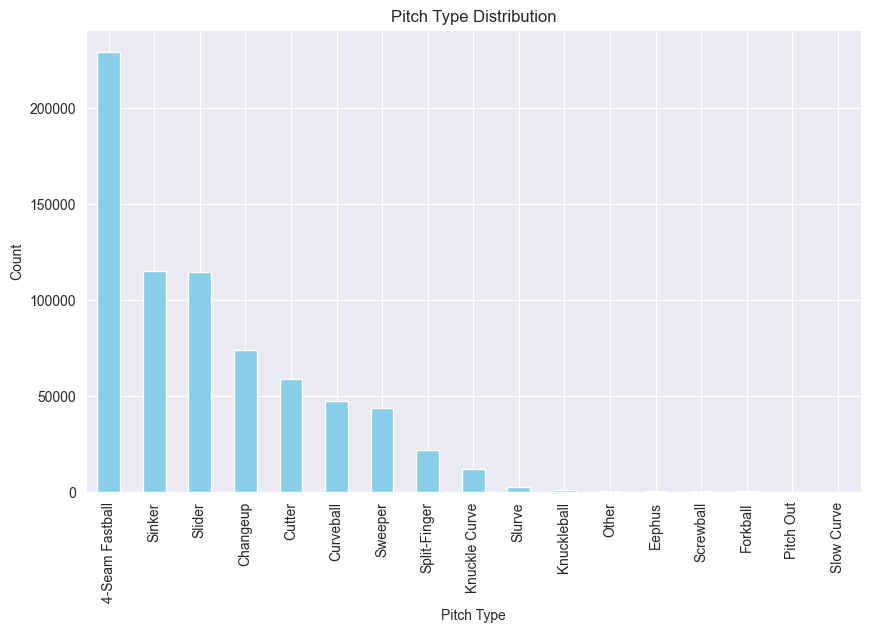

In [154]:
pitch_type_counts = pitches_cleaned['pitch_name'].value_counts()
print(pitch_type_counts)

plt.figure(figsize=(10,6))
pitch_type_counts.plot(kind='bar', color='skyblue')
plt.title('Pitch Type Distribution')
plt.xlabel('Pitch Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

I decided to filter out pitchouts and pitches labelled "other". Pitchouts depend much more on the game situation and which runner(s) are on base than the pitcher or batter, so I belive prediction of pitchouts belongs in a different study. Filtering out the "other" category seems necessary because there is no consistency in what the pitches will be so it does not seem useful to predict.

Also, I considered filtering out other rare classes at this point (fewer than 1000 thrown across all pitchers for the whole season) but decided in the end to keep knuckleball, eephus pitch, screwball, forkball, and slow curve in the dataset becasuse their sequencing with more common pitch types seems important. Later model performance does not improve dramatically when we remove these pitch types because they are just so rare.

In [155]:
not_to_predict = ['Other', 'Pitch Out']
pitches_cleaned = pitches_cleaned[~pitches_cleaned['pitch_name'].isin(not_to_predict)].reset_index(drop=True)

A couple more columns I want to investigate for future feature engineering: the length of at bats in our data and the size of pitcher repertoires.

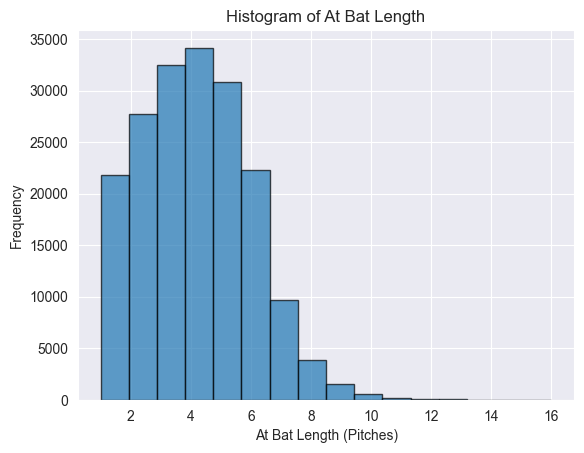

In [156]:
pitches_cleaned['is_final_pitch'] = (pitches_cleaned['pitch_number'] == pitches_cleaned.groupby(['game_pk', 'at_bat_number'])['pitch_number'].transform('max')).astype(int)

at_bat_lengths = pitches_cleaned.loc[pitches_cleaned['is_final_pitch'] == 1]['pitch_number']

plt.hist(at_bat_lengths, bins=max(pitches_cleaned['pitch_number']), edgecolor='k', alpha=0.7)
plt.title("Histogram of At Bat Length")
plt.xlabel("At Bat Length (Pitches)")
plt.ylabel("Frequency")
plt.show()

It is rare for at bats to last more than six pitches. I probably only want to look back a few pitches in an at bat since it would create many missing values to look back further.

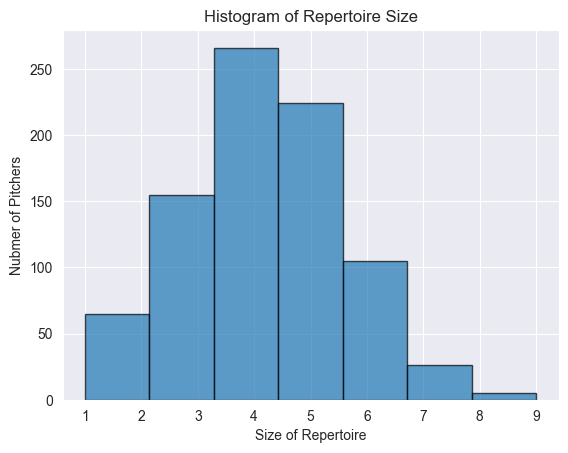

In [157]:
repertoire_sizes = pitches_cleaned.groupby('pitcher')['pitch_type'].nunique()

plt.hist(repertoire_sizes, bins=7, edgecolor='k', alpha=0.7)
plt.title("Histogram of Repertoire Size")
plt.xlabel("Size of Repertoire")
plt.ylabel("Nubmer of Pitchers")
plt.show()

# Feature Engineering

The purpose of this section is to construct feature columns that will be predictive for a future pitch. Characteristics of the pitch we want to predict cannot be used, but I attempt to synthesize past events to make useful new columns.

In [158]:
def reset_usage(df, granularities, result):
    granularities_string = '_'.join(granularities)
    relevant_columns_to_reset = [col for col in result.columns if granularities_string in col]

    # Group by all relevant columns to reset
    reset_indices = df.groupby(granularities).head(1).index
    result.loc[reset_indices, relevant_columns_to_reset] = 0
    return result

In [159]:
def calculate_usage_percentages(df, groupby_columns):
    # Create cumulative counts for all pitch types
    cumulative_counts = (
        df.assign(is_pitch=1)
        .pivot_table(
            index=[*groupby_columns, df.index],
            columns='pitch_type',
            values='is_pitch',
            fill_value=0,
        )
        .groupby(level=groupby_columns)
        .cumsum()
        .shift(1)  # Exclude the current pitch
        .fillna(0)
    )

    cumulative_counts.reset_index(level=len(groupby_columns), drop=True, inplace=True)

    # Calculate total cumulative pitches for each row and normalize
    cumulative_totals = cumulative_counts.sum(axis=1)
    usage_percentages = cumulative_counts.div(cumulative_totals, axis=0).fillna(0)

    usage_percentages.index = df.index
    result = usage_percentages.add_suffix(f'_{"_".join(groupby_columns)}_usage_pct')

    # Apply the function to reset columns at the beginning of each lookback period, defined by the columns passed in
    result = reset_usage(df, groupby_columns, result)
    return result

In [160]:
# Calculate usage percentages for each granularity
season_usage_pct = calculate_usage_percentages(pitches_cleaned, ['pitcher'])
game_usage_pct = calculate_usage_percentages(pitches_cleaned, ['pitcher', 'game_pk'])
inning_usage_pct = calculate_usage_percentages(pitches_cleaned, ['pitcher', 'game_pk', 'inning'])
at_bat_usage_pct = calculate_usage_percentages(pitches_cleaned, ['pitcher', 'game_pk', 'inning', 'at_bat_number'])

# Join the usage percentage columns back into the original DataFrame
with_all_usages = pitches_cleaned.join(season_usage_pct).join(game_usage_pct).join(inning_usage_pct).join(at_bat_usage_pct).reset_index(drop=True)

Here I use previous pitches thrown to produce usage percents for different pitch types at the time of every pitch. Further, I document those usages on the level of the game, the inning, and the at bat up to the pitch in question.

In [161]:
def get_repertoire_from_usages(row, usages, size):
    #Create a dictionary of the pitches and their usages and sort
    pitch_usage_dict = {col.split('_')[0]: row[col] for col in usages}
    sorted_pitches = sorted(pitch_usage_dict.items(), key=lambda x: x[1], reverse=True)

    repertoire = [pitch for pitch, pct in sorted_pitches if pct > 0]
    repertoire += [None] * (size - len(repertoire))

    return {f'repertoire_{i+1}': repertoire[i] for i in range(size)}

In [162]:
repertoire_size = 5 #Chosen based on distribution of pitcher repertoire sizes
season_usage_pct_columns = [col for col in with_all_usages.columns if col.endswith('_pitcher_id_usage_pct')]

repertoire_cols = [f'repertoire_{i+1}' for i in range(repertoire_size)]
with_all_usages[repertoire_cols] = with_all_usages.apply(
    lambda row: get_repertoire_from_usages(row, season_usage_pct_columns, repertoire_size),
    axis=1,
    result_type="expand"
)
built_categorical_cols = repertoire_cols

These categorical columns contain the five most common pitch types in a pitcher's arsenal up to this point in the season. In practice these columns would probably be built on data from previous seasons or known repertoires.

In [163]:
n_most_recent = 3 #Chosen based on distribution of at bat lengths
for n in range(1, n_most_recent + 1):
    # Create columns for the nth previous pitch type
    with_all_usages[f'previous_pitch_type_in_at_bat_{n}'] = (
        with_all_usages.groupby(['pitcher', 'game_pk', 'at_bat_number'])['pitch_type'].shift(n)
    )
    with_all_usages[f'previous_pitch_type_in_at_bat_{n}'] = (
        with_all_usages[f'previous_pitch_type_in_at_bat_{n}'].fillna('None')
    )

    # Create columns for the nth previous coarse pitch result
    with_all_usages[f'previous_pitch_result_coarse_in_at_bat_{n}'] = (
        with_all_usages.groupby(['pitcher', 'game_pk', 'at_bat_number'])['type'].shift(n)
    )
    with_all_usages[f'previous_pitch_result_coarse_in_at_bat_{n}'] = (
        with_all_usages[f'previous_pitch_result_coarse_in_at_bat_{n}'].fillna('None')
    )

    #Combine the two because they should interact in these pairs when constructing models
    with_all_usages[f'previous_pitch_type_and_result_coarse_in_at_bat_{n}'] = with_all_usages[f'previous_pitch_type_in_at_bat_{n}'] + "_" + with_all_usages[f'previous_pitch_result_coarse_in_at_bat_{n}']

These categorical columns contain the previous three pitch types thrown in the at bat, the results of those pitches, and a concatenation of the two. I use the type column here instead of pitch_des because breaking up the results more finely will lead to noise if multiple pitch descriptions impact pitch selection the same way. I believe the added noise will outweigh the added predictive power of distinguishing swinging strikes from looking strikes and similar distinctions.

In [164]:
encoder = OneHotEncoder(sparse_output=False)
columns_to_encode = (
    [f'previous_pitch_type_in_at_bat_{n}' for n in range(1, n_most_recent + 1)] +
    [f'previous_pitch_result_coarse_in_at_bat_{n}' for n in range(1, n_most_recent + 1)] +
    [f'previous_pitch_type_and_result_coarse_in_at_bat_{n}' for n in range(1, n_most_recent + 1)]
)
built_categorical_cols += columns_to_encode

encoded_data = encoder.fit_transform(with_all_usages[columns_to_encode])
categories = encoder.categories_
encoded_column_names = []
for i, col in enumerate(columns_to_encode):
    encoded_column_names += ['{}_{}'.format(col, category) for category in categories[i]]

encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)

with_all_usages_encoded = pd.concat([with_all_usages, encoded_df], axis=1)

I use one-hot encoding to produce numerical features from categorical features. This allows for more types of machine learning models to make use of the new features. The main drawback is that it greatly increases the dimensionality of our dataset and leads to sparse data with lots of zeros, issues we must keep in mind when passing these columns to models.

In [165]:
final_cleaned_with_features = with_all_usages_encoded

# Model Building

Now we have a data frame with lots of features and will build several models to predict the next pitch type. For each one, we select features from our columns to create an input table X which should predict an output table y. I look at logistic regression, random forests, categorical boosting, and neural networks.

In addition to the models shown below I also considered a naive Bayes approach but was unable to fit a reasonable model, probably because the features were correlated and not normally distributed, and I was trying to predict a categorical variable with several uncommon classes. Further attempts to fit a naive Bayes model would involve the creation of different features from the ones I made.

### Logistic Regression

In [166]:
#Using season usages and game situation
log_reg_cols = [col for col in final_cleaned_with_features.columns if
                'pitcher_id_usage_pct' in col or
                col in ['balls','strikes','outs_when_up']]

X = final_cleaned_with_features[log_reg_cols]
y = final_cleaned_with_features['pitch_type']

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', LogisticRegression(solver='lbfgs', max_iter=1000))
])

cv_log_loss = cross_val_score(pipe, X, y, cv=5, scoring='neg_log_loss')
cv_log_loss = -cv_log_loss
print(f"Cross-validated log loss scores: {cv_log_loss}")
print(f"Mean log loss: {np.mean(cv_log_loss)}")
print(f"Standard deviation: {np.std(cv_log_loss)}")

Cross-validated log loss scores: [1.93506512 1.93468257 1.93478983 1.9287411  1.92902372]
Mean log loss: 1.9324604667863912
Standard deviation: 0.002925504755771453


Logistic regression is a good tool, but it has limitations. It does not take categorical variables, so would require some kind of encoding to accept things like previous pitch. But logistic regression also struggles with a large number of inputs so given the number of pitch types we're trying to predict the one-hot encoding is impractical. The performance is decent given the limited set of features being used but not what we are looking for.

### Random Forests

In [167]:
#Using season usages and game situation
rf_cols = [col for col in final_cleaned_with_features.columns if
                'pitcher_id_usage_pct' in col or
                col in ['balls','strikes','outs_when_up']]

X = final_cleaned_with_features[rf_cols]
y = final_cleaned_with_features['pitch_type']

#Scaling not necessarily required for random forests
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

cv_log_loss = cross_val_score(pipe, X, y, cv=5, scoring='neg_log_loss')
cv_log_loss = -cv_log_loss
print(f"Cross-validated log loss scores: {cv_log_loss}")
print(f"Mean log loss: {np.mean(cv_log_loss)}")
print(f"Standard deviation: {np.std(cv_log_loss)}")

Cross-validated log loss scores: [1.92632842 1.92564533 1.92802264 1.91957864 1.91992325]
Mean log loss: 1.923899657479416
Standard deviation: 0.003476441205519584


I could not get random forests to produce a better model for this task. Similarly to logistic regression, random forests do not accept categorical variables, but I show an attempt where I pass in sparsely populated season usage columns. The issue here is that the pitcher's one or two most used pitches will be by far the most predictive features, and if a tree in our forest is not allowed to split on those features it will be very bad.

### Categorical Boosting
This is a reasonable dataset for categorical boosting as it contains several categorical features, our dataset has high dimensionality, and it is imbalanced with respect to the different pitch frequencies. Categorical boosting is notorious for long runtime, so I have included an example with relatively few features.

In [177]:
#Using a small subset of potential features
cat_boost_cols = [col for col in final_cleaned_with_features.columns if
                  #'pitcher_id_usage_pct' in col or
                  'repertoire' in col or
                  col in built_categorical_cols or
                  col in ['balls', 'strikes', 'outs_when_up']]

X = final_cleaned_with_features[cat_boost_cols]
y = final_cleaned_with_features['pitch_type']

non_numeric_cols = X.select_dtypes(include=['object']).columns
X.loc[:, non_numeric_cols] = X[non_numeric_cols].astype(str)  # Use .loc to avoid the warning


cat_feature_indices = [X.columns.get_loc(col) for col in non_numeric_cols]
model = CatBoostClassifier(n_estimators=100, random_state=42, verbose=0, cat_features=cat_feature_indices)

cv_log_loss = cross_val_score(model, X, y, cv=5, scoring='neg_log_loss')
cv_log_loss = -cv_log_loss
print(f"Cross-validated log loss scores: {cv_log_loss}")
print(f"Mean log loss: {np.mean(cv_log_loss)}")
print(f"Standard deviation: {np.std(cv_log_loss)}")

Cross-validated log loss scores: [1.70854847 1.72545578 1.72129678 1.68069244 1.70343229]
Mean log loss: 1.7078851528573822
Standard deviation: 0.015800698815231683


The features provided to train the categorical boosting model above are insufficient to make accurate predictions but larger feature spaces take increasingly long times to run. I was able to produce marginally better results than the one shown but still nothing that approached the predictive power of the logistic regression model.

I was unable to produce significantly better results by including information about pitch type usage percents or previous pitches in the at bat.

### Neural Networks

This seems like a very natural task for neural nets. A lot of the features that seemed intuitive were numerical and on similar scales, and neural nets can handle the large number of features that come about when we encode categorical variables containing many possible classes.

In [178]:
neural_net_cols = [col for col in final_cleaned_with_features.columns if
                    'usage_pct' in col or
                    re.search(r'previous_pitch_type_and_result_coarse_in_at_bat_[123]_', col) or
                    col in ['balls', 'strikes', 'outs_when_up']]

X = with_all_usages_encoded[neural_net_cols]
y = with_all_usages_encoded['pitch_type']

In [179]:
X_scaled = StandardScaler().fit_transform(X)
y_encoded = OneHotEncoder(sparse_output=False).fit_transform(y.values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

#Define a custom estimator for the Keras model with adjustable layers and nodes
class KerasModel(BaseEstimator):
    def __init__(self, activation='relu', learning_rate=0.001, num_layers=2, num_nodes=64):
        self.activation = activation
        self.learning_rate = learning_rate
        self.num_layers = num_layers
        self.num_nodes = num_nodes
        self.model = None

    def build_model(self):
        model = Sequential()
        #Input layer
        model.add(Input(shape=(X_train.shape[1],)))

        #Hidden layers
        for _ in range(self.num_layers):
            model.add(Dense(self.num_nodes, activation=self.activation))

        #Output layer
        model.add(Dense(y_train.shape[1], activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, epochs=10, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        loss, accuracy = self.model.evaluate(X, y, verbose=0)
        return loss

param_grid = {
    'activation': ['relu'],
    'learning_rate': [0.001],
    'num_layers': [2, 3, 4],
    'num_nodes': [20, 32, 64]
}

model = KerasModel()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
test_loss = best_model.score(X_test, y_test)
print(f"Test Loss: {test_loss:.2f}")

Best Hyperparameters:  {'activation': 'relu', 'learning_rate': 0.001, 'num_layers': 4, 'num_nodes': 64}
Test Loss: 1.27


This is an example of a grid search where I iterate over two model parameters. I searched over more extensive grids but the runtimes of those searches were very long.

In [180]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(72, activation='relu'),
    Dense(48, activation='relu'),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

Epoch 1/10
14405/14405 - 9s - 649us/step - accuracy: 0.4270 - loss: 1.4412 - val_accuracy: 0.4369 - val_loss: 1.3398
Epoch 2/10
14405/14405 - 9s - 598us/step - accuracy: 0.4434 - loss: 1.3142 - val_accuracy: 0.4420 - val_loss: 1.3083
Epoch 3/10
14405/14405 - 8s - 587us/step - accuracy: 0.4467 - loss: 1.2920 - val_accuracy: 0.4457 - val_loss: 1.2937
Epoch 4/10
14405/14405 - 8s - 589us/step - accuracy: 0.4493 - loss: 1.2799 - val_accuracy: 0.4477 - val_loss: 1.2842
Epoch 5/10
14405/14405 - 9s - 595us/step - accuracy: 0.4513 - loss: 1.2718 - val_accuracy: 0.4486 - val_loss: 1.2791
Epoch 6/10
14405/14405 - 9s - 591us/step - accuracy: 0.4521 - loss: 1.2659 - val_accuracy: 0.4498 - val_loss: 1.2753
Epoch 7/10
14405/14405 - 8s - 582us/step - accuracy: 0.4538 - loss: 1.2615 - val_accuracy: 0.4499 - val_loss: 1.2721
Epoch 8/10
14405/14405 - 8s - 585us/step - accuracy: 0.4543 - loss: 1.2578 - val_accuracy: 0.4479 - val_loss: 1.2725
Epoch 9/10
14405/14405 - 8s - 580us/step - accuracy: 0.4549 - lo

Fine-tuning and experimentation led me to this final neural network model with different numbers of nodes in each layer.

# Findings

The neural network approach was the most predictive, with a categorical cross-entropy of 1.27. Categorical cross-entropy is a generalized form of log loss meant for specifically for multi-class classification problems, so it compares directly to the log loss calculated for other models. The value of 1.27 would be relatively high for many machine learning problems, but in this project pitchers are actively trying to stay unpredictable. For reference, if the model assigned a probability of 0.28 to the correct pitch type every time it would achieve a similar performance. Here I look into where the model proved predictive and where it came up short.

In [172]:
pitch_types = encoder.categories_[0]
true_class_indices = np.argmax(y_test, axis=1)

label_encoder = LabelEncoder()
label_encoder.fit(y)

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

4502/4502 ━━━━━━━━━━━━━━━━━━━━ 1s 226us/step


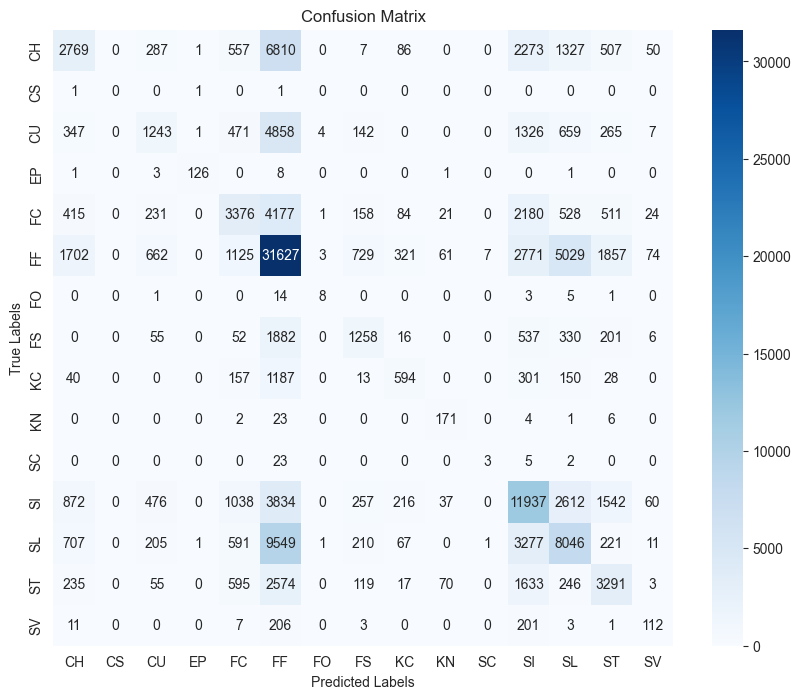

In [173]:
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

indices_to_pitches = {v: k for k, v in label_mapping.items()}
labels = [indices_to_pitches.get(i, None) for i in range(len(indices_to_pitches))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix compares the true pitch type to the type a model assigns the greatest probability. It is useful to determine which pitch the model is predicting as most likely when its first choice is incorrect. Unsurprisingly in most of our incorrect predictions we predict four-seam fastball, which is the most common pitch type and features prominently in the repertoire of most pitchers. I'm slightly surprised there isn't more confusion between off-speed offerings like CU and CH. For our task, though, we are more interested in the distributions of probabilities associated with the correct pitch types.

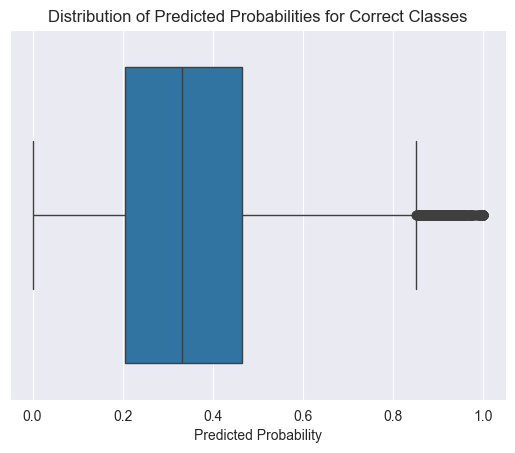

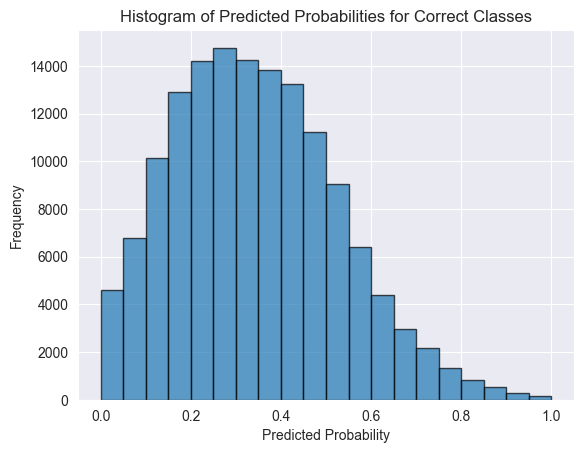

In [174]:
correct_class_probs = y_pred_probs[np.arange(len(y_pred_probs)), true_class_indices]

sns.boxplot(x=correct_class_probs)
plt.title("Distribution of Predicted Probabilities for Correct Classes")
plt.xlabel("Predicted Probability")
plt.show()

plt.hist(correct_class_probs, bins=20, edgecolor='k', alpha=0.7)
plt.title("Histogram of Predicted Probabilities for Correct Classes")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

These are our prediction probabilities assigned to the correct answer. While it's good to get an overall impression, we need to look at each pitch type individually due to the imbalanced nature of our dataset. The model is likely to perform very differently on different pitch types.

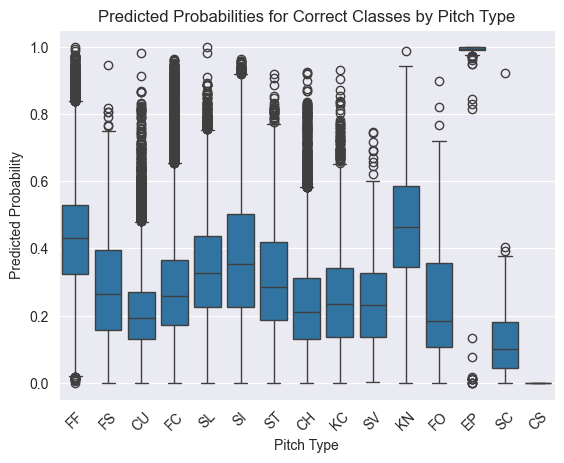

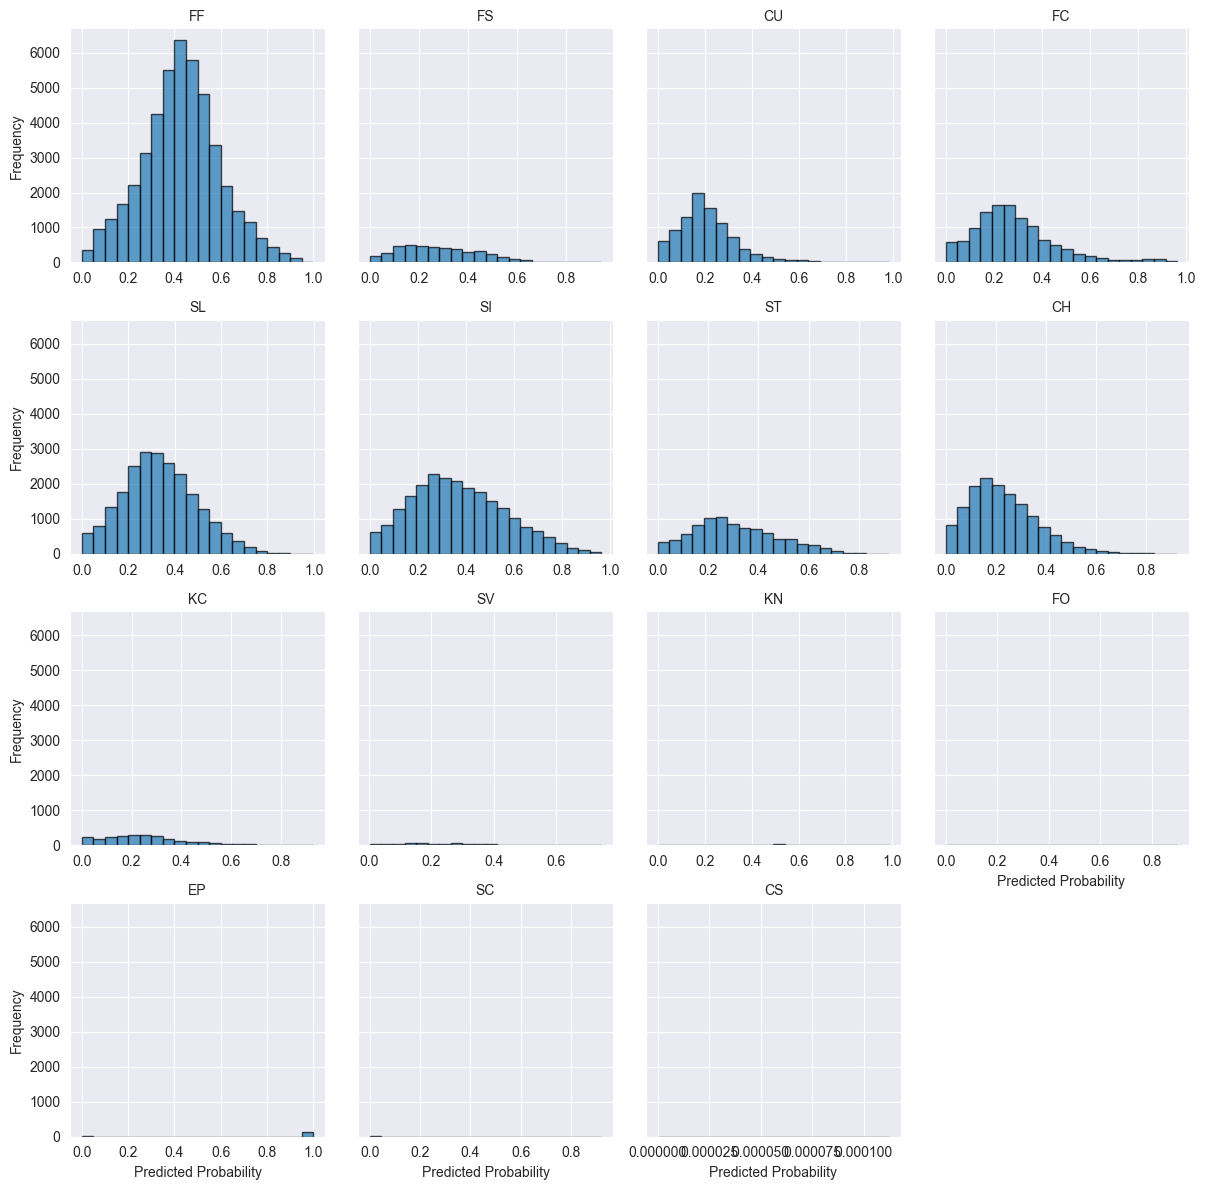

In [175]:
data = pd.DataFrame({
    "Pitch Type": [pitch_types[i] for i in true_class_indices],
    "Predicted Probability": correct_class_probs
})

sns.boxplot(x="Pitch Type", y="Predicted Probability", data=data)
plt.title("Predicted Probabilities for Correct Classes by Pitch Type")
plt.xticks(rotation=45)
plt.show()

g = sns.FacetGrid(data, col="Pitch Type", col_wrap=4, sharex=False, sharey=True)
g.map(plt.hist, "Predicted Probability", bins=20, edgecolor="k", alpha=0.7)
g.set_titles("{col_name}")
g.set_axis_labels("Predicted Probability", "Frequency")
plt.show()

Breaking things down by pitch shows a few things. The model is very good at predicting eephus pitches, which makes sense given that only a few pitchers throw the pitch at all. I am somewhat surprised that the model struggles to predict changeups and curveballs, even relative to cutters which are used even less often.

I kept the scale consistent because it is important to view these results in the context of the pitchs' overall frequencies in the data. The histograms for pitchout, screwball, forkball, and eephus pitch are too small to see and those distributions can be viewed in the box and whisker plots.

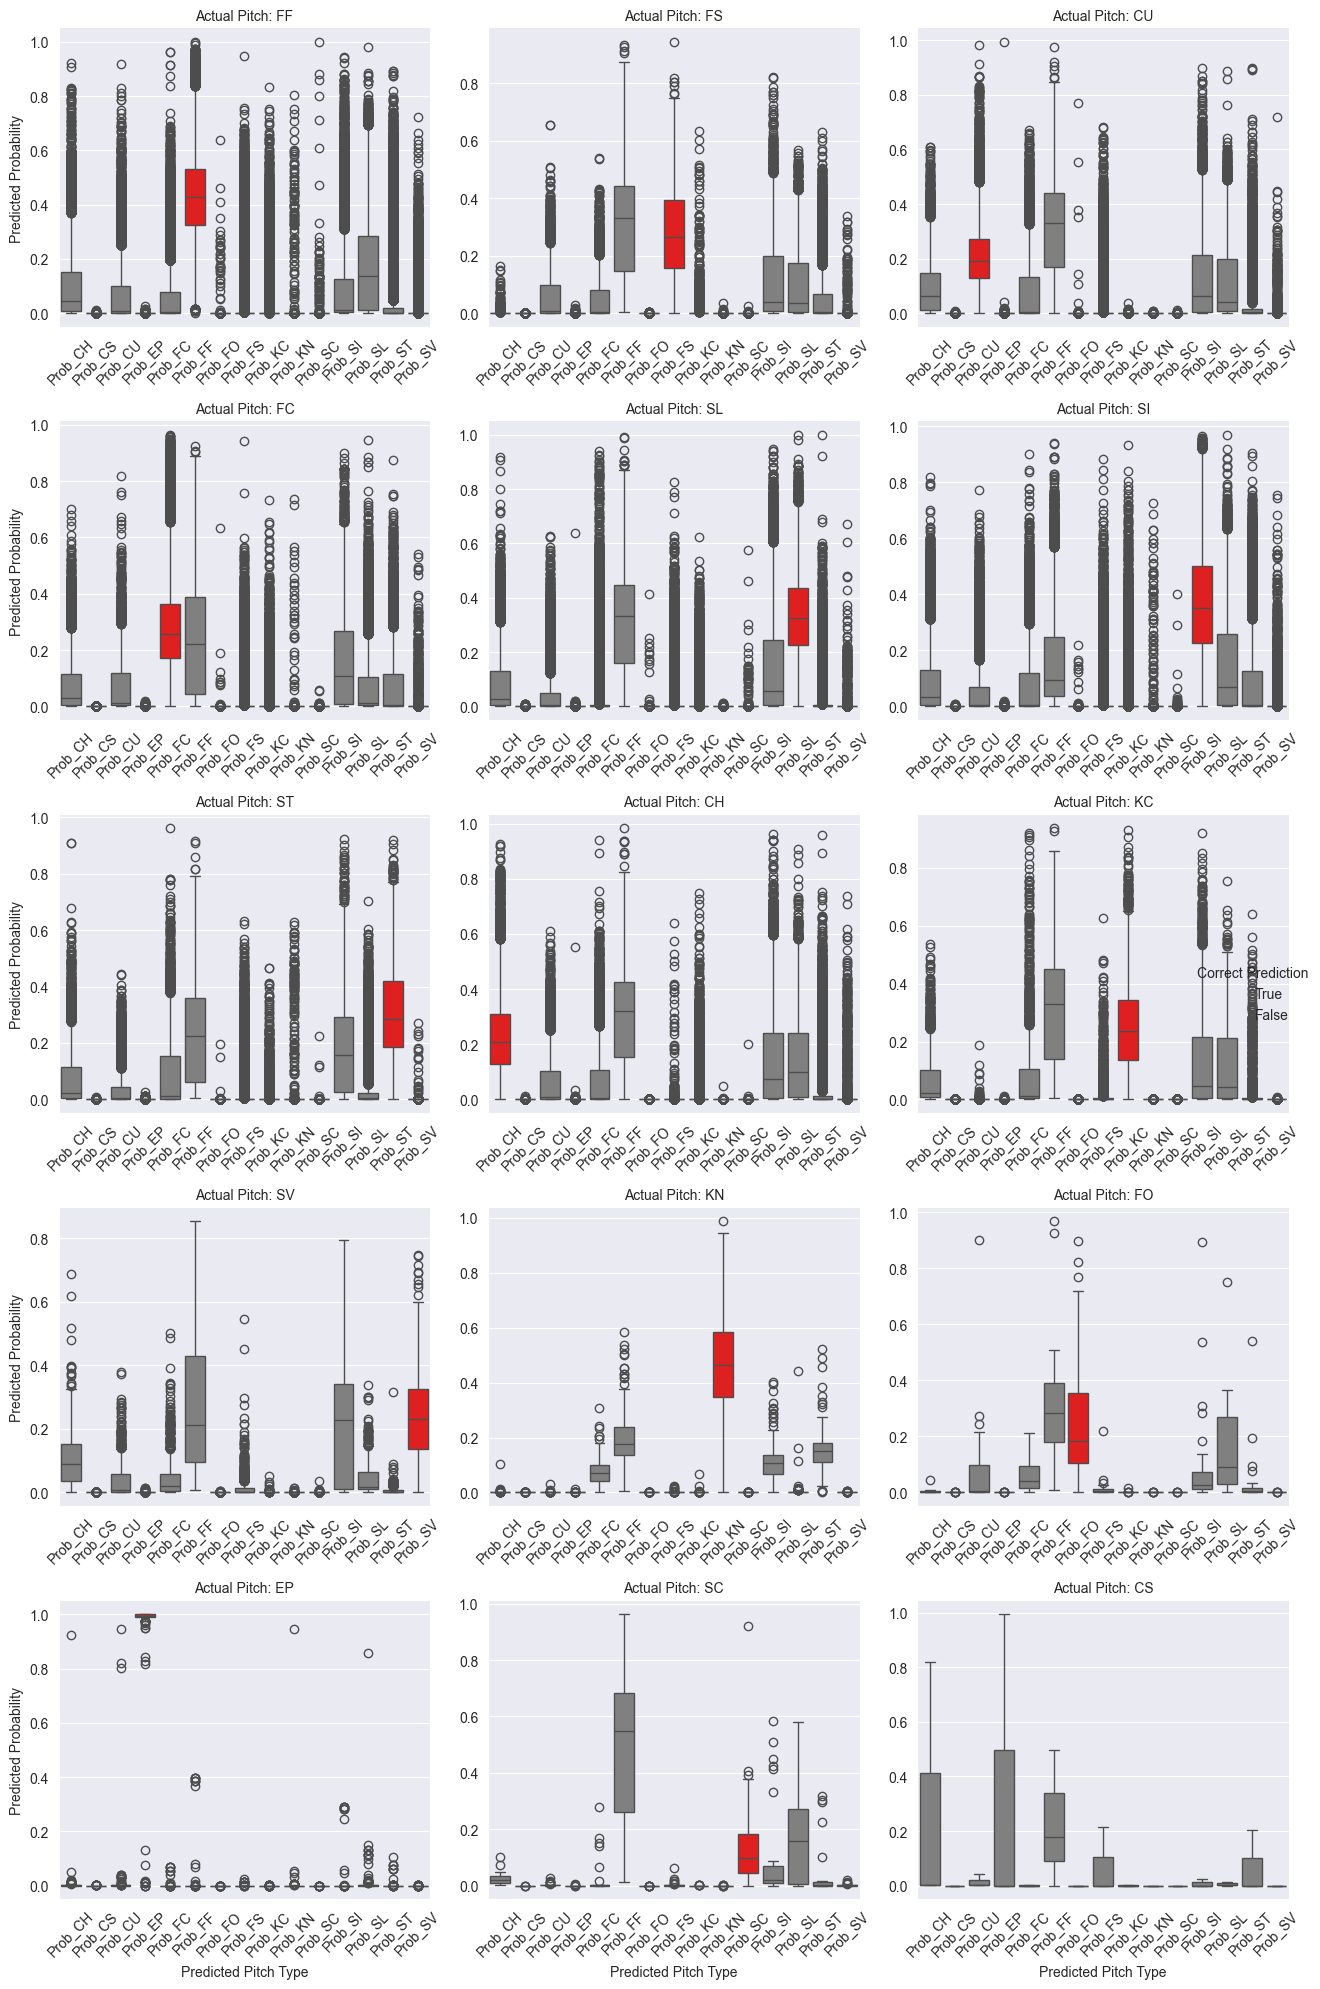

In [176]:
#Predicted probabilities and true pitch types
data = pd.DataFrame(y_pred_probs, columns=[f"Prob_{pt}" for pt in pitch_types])
data["Actual"] = [pitch_types[i] for i in true_class_indices]

melted_data = data.melt(id_vars="Actual", var_name="Predicted Pitch Type", value_name="Probability")
melted_data['Predicted Pitch Type Cleaned'] = melted_data['Predicted Pitch Type'].str.replace('Prob_', '')
#Correct prediction to be colored in red
melted_data['Correct Prediction'] = melted_data['Predicted Pitch Type Cleaned'] == melted_data['Actual']

g = sns.FacetGrid(melted_data, col="Actual", col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(
    sns.boxplot,
    x="Predicted Pitch Type",
    y="Probability",
    hue="Correct Prediction",
    palette={True: 'red', False: 'gray'},
    dodge=False
)
g.set_titles("Actual Pitch: {col_name}")
g.set_axis_labels("Predicted Pitch Type", "Predicted Probability")

for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

g.add_legend(title="Correct Prediction", label_order=[True, False])
plt.tight_layout()
plt.show()

The red boxes in each of these plots corresponds to one of the plots in the boxplot for predicted probability of correct class. The grey boxes show distributions for where the model was assigning the missing probability for each actual pitch type. This is similar to a confusion matrix but respects the probabilistic nature of the prediction task. This further backs up the claim from the confusion matrix that curveballs and change ups are not being overly confused with one another.

# Conclusion

Overall the neural net model performed adequately for our prediction task. Some pitches, like knuckleballs, were understandably easy to predict, while other offspeed offerings were more challenging. Categorical boosting, random forests, and logistic regression models ended up producing passable results but naive Bayes attempts fell flat. There is ample room for future work, both attempting to fit different kinds of models and especially in the creation of different new features. I would like to try other boosting algorithms after categorical boosting performed worse than I had hoped. In terms of potential features, there are countless ways to proceed.

To begin with, I use previous pitches thrown, but it would also be interesting to see if changes in pitch metrics over the course of a game would affect future usages. If a pitcher's spin rate on curveballs is unusually low in the first couple innings of a game it seems reasonable to move away from that pitch. I could imagine coming up with a composite score of pitch effectiveness on the day based on the events it has produced, because pitchers are also likely inclined to stick with what has been producing good results. Most glaringly, though, I do not make use of batter data. Some batters have trouble with breaking balls and would be approached differently by all pitchers, and I do not try to capture any of those trends. This could also interact with game situation in interesting ways that are not addressed here.